# Exercise 2b)

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 1
%aimport utils.neural_network, utils.training, utils.step_methods, utils.cost_functions, utils.activation_functions, utils.utils

# Imports
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import TrainingMethod, StochasticGradientDescent, GradientDescent
from utils.step_methods import StepMethod, RMSpropStep, AdamStep
from utils.cost_functions import MSE
from utils.activation_functions import Sigmoid, Identity
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utils.utils import generate_dataset, runge, plot_mse_data, analyze_model_learning_rates
from copy import deepcopy

plt.style.use('./utils/_plot_style.mplstyle')

In [ ]:
# Generate dataset
np.random.seed(124)

n = 300
x, y = generate_dataset(num=n)

In [3]:
# OLS model
ols_model = make_pipeline(
    PolynomialFeatures(degree=12, include_bias=False),
    StandardScaler(),
    LinearRegression(fit_intercept=False)
)

In [4]:
# Neural network model
network_input_size = x.shape[1]
network_output_size = 1

layer_output_sizes = [50, 50, network_output_size]
activation_funcs = [Sigmoid(), Sigmoid(), Identity()]

nn_model = NeuralNetwork(
    network_input_size,
    layer_output_sizes,
    activation_funcs,
    MSE(),
)
nn_scaler = StandardScaler() # Scaler for neural network input data

In [5]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=44)

nn_mse = np.zeros(n_splits)
ols_mse = np.zeros(n_splits)


for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scale data
    x_train_scaled = nn_scaler.fit_transform(x_train)
    x_test_scaled = nn_scaler.transform(x_test)
    y_mean = y_train.mean()

    # Train and evaluate Neural Network
    nn_model.reset_layers(random_state=123) # Reset neural network layers
    mse_data = nn_model.train(
        StochasticGradientDescent(
            step_method = RMSpropStep(learning_rate=0.01, decay_rate=0.9),
            inputs = x_train_scaled,
            targets = y_train - y_mean,
            test_inputs = x_test_scaled,
            test_targets = y_test - y_mean
        ),
        num_iterations = 3000,
        track_mse = True
    )
    y_pred_nn = nn_model.predict(x_test_scaled) + y_mean
    nn_mse[fold_idx] = MSE()(y_pred_nn, y_test)

    # Train and evaluate OLS model
    ols_model.fit(x_train, y_train - y_mean) # This model already includes a scaler
    y_pred_ols = ols_model.predict(x_test) + y_mean
    ols_mse[fold_idx] = MSE()(y_pred_ols, y_test)


In [6]:
print(f"{n_splits}-fold {'NN MSE:':10} {nn_mse.mean():.3e}")
print(f"{n_splits}-fold {'OLS MSE:':10} {ols_mse.mean():.3e}")

5-fold NN MSE:    2.895e-03
5-fold OLS MSE:   3.384e-03


## Plot mse over iterations for the last fold

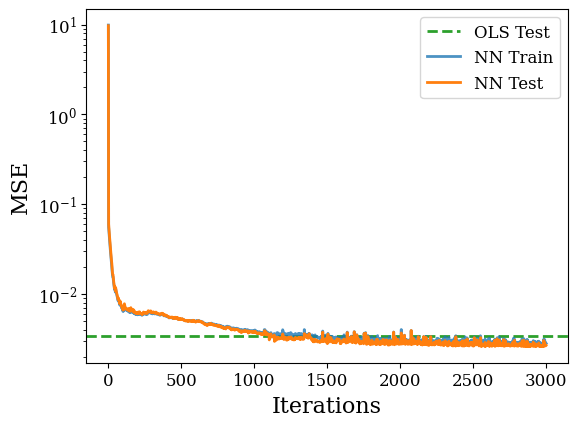

In [7]:
plt.axhline(ols_mse[-1], color="C2", linestyle="--")
plot_mse_data(mse_data[::2]) # Plot every second point to reduce clutter from fluctuations
plt.legend(["OLS Test", "NN Train", "NN Test"])
plt.savefig("../figs/mse_nn_vs_ols.pdf")
plt.show()

## Visualize the function approximation with NN and OLS for the last fold

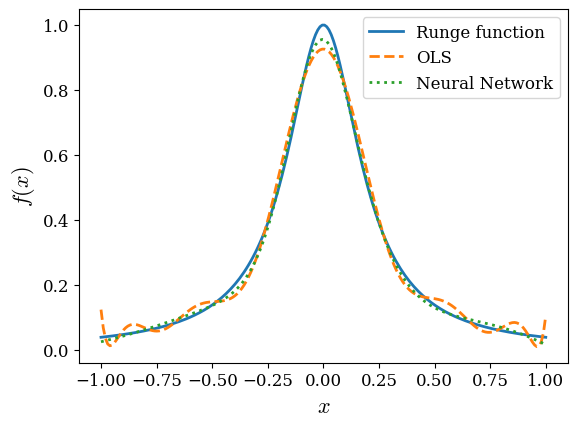

In [8]:
x_test = np.linspace(-1,1, 200).reshape(-1, 1)

y_pred_nn = nn_model.predict(nn_scaler.transform(x_test)) + y_mean
y_pred_ols = ols_model.predict(x_test) + y_mean


plt.plot(x_test, runge(x_test), label="Runge function")
plt.plot(x_test, y_pred_ols, linestyle="dashed", label="OLS")
plt.plot(x_test, y_pred_nn, linestyle="dotted", label="Neural Network")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.savefig("../figs/runge_approximation_nn_vs_ols.pdf")
plt.show()

## MSE vs. Learning rates for different models

In [ ]:
# Generate dataset
np.random.seed(124)

n = 300
x, y = generate_dataset(num=n)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=44)

# Scale dataset
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_mean = y_train.mean()

In [10]:
# Define models
model_50 = NeuralNetwork(
    network_input_size = 1,
    layer_output_sizes = [50, 1],
    activation_funcs = [Sigmoid(), Identity()],
    cost_fun = MSE()
)
model_50_50 = NeuralNetwork(
    network_input_size = 1,
    layer_output_sizes = [50, 50, 1],
    activation_funcs = [Sigmoid(), Sigmoid(), Identity()],
    cost_fun = MSE()
)

models = [
    ("50 hidden", model_50),
    ("50+50 hidden", model_50_50)
]

# Define training methods
training_methods: list[tuple[str, type[TrainingMethod], tuple[int, int]]] = [
    ("SGD", StochasticGradientDescent, (-4, 0)),
    ("GD", GradientDescent, (-6, -2)),
]

# Step methods
step_methods: list[tuple[str, StepMethod]] = [
    ("RMSprop", RMSpropStep(0, 0.9)), 
    ("ADAM", AdamStep(0, 0.9, 0.999))
]

In [11]:
n_learning_rates = 9
num_iterations = 3000
all_mse_data = np.zeros((len(models), len(training_methods), len(step_methods),n_learning_rates))

# Analyze mse vs. learning rates for each combination of model, training method, and step method
for i, (model_title, model) in enumerate(models):
    print(model_title)
    for j, (training_method_name, training_method, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        print(f"\t{training_method_name} - LR range: [{10**min_log_lr:.1e}, {10**max_log_lr:.1e}]")
        for k, (step_method_name, step_method) in enumerate(step_methods):
            print(f"\t\t{step_method_name}", end="")

            learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))

            np.random.seed(124)
            mse_data = analyze_model_learning_rates(
                model,
                training_method(
                    step_method = step_method,
                    inputs = x_train_scaled,
                    targets = y_train - y_mean,
                    test_inputs = x_test_scaled,
                    test_targets = y_test - y_mean,
                ),
                learning_rates, 
                num_iterations,
            )
            print(".")
            all_mse_data[i][j][k] = mse_data


50 hidden
	SGD - LR range: [1.0e-04, 1.0e+00]
		RMSprop.
		ADAM.
	GD - LR range: [1.0e-06, 1.0e-02]
		RMSprop.
		ADAM.
50+50 hidden
	SGD - LR range: [1.0e-04, 1.0e+00]
		RMSprop.
		ADAM.
	GD - LR range: [1.0e-06, 1.0e-02]
		RMSprop.
		ADAM.


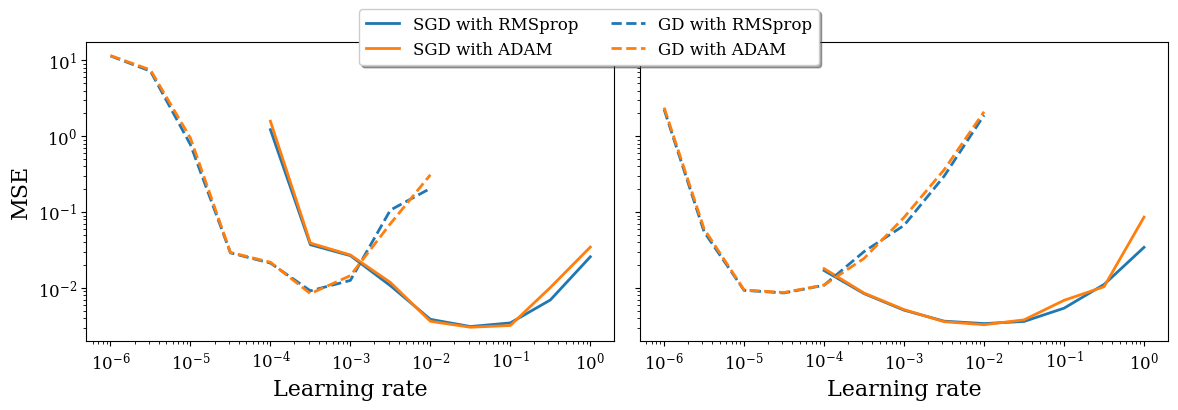

In [12]:
# Plot MSE vs. learning rates for each model

fig, axes = plt.subplots(1, len(models), figsize=(12, 4), sharey=True)
for i, (model_title, _) in enumerate(models):
    for j, (training_method_name, _, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))
        for k, (step_method_name, _) in enumerate(step_methods):
            mse_data = all_mse_data[i][j][k]
            axes[i].plot(learning_rates, mse_data, 
                     label=f"{training_method_name} with {step_method_name}", 
                     c=f"C{k}", 
                     linestyle = "-" if j == 0 else "--",
            )
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Learning rate")
axes[0].set_ylabel("MSE")
single_legends = axes[0].get_legend_handles_labels()
fig.legend(
    handles=single_legends[0], labels=single_legends[1], 
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=2, fancybox=True, shadow=True
)
plt.savefig("../figs/mse_vs_lr.pdf")
plt.show()

## MSE vs. iterations, for each model using best learning rate found

In [13]:
best_learning_rates_idx = np.argmin(all_mse_data, axis=3)

In [14]:
all_mse_track_data = np.zeros((len(models), len(training_methods), len(step_methods), num_iterations, 2))

single_learning_rate = [learning_rates[5]]

# Analyze mse vs. learning rates for each combination of model, training method, and step method
for i, (model_title, model) in enumerate(models):
    print(model_title)
    for j, (training_method_name, training_method, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        print(f"\t{training_method_name} - LR range: [{10**min_log_lr:.1e}, {10**max_log_lr:.1e}]")
        for k, (step_method_name, step_method) in enumerate(step_methods):
            print(f"\t\t{step_method_name}", end="")

            learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))

            np.random.seed(124)
            model.reset_layers(random_state=124)
            step_method.learning_rate = learning_rates[best_learning_rates_idx[i][j][k]] # Set to best learning rate found
            mse_data = model.train(
                training_method(
                    step_method = step_method,
                    inputs = x_train_scaled,
                    targets = y_train - y_mean,
                    test_inputs = x_test_scaled,
                    test_targets = y_test - y_mean,
                ),
                num_iterations = num_iterations,
                n_batches=5,
                track_mse = True
            )
            all_mse_track_data[i][j][k] = mse_data[:,[0,2]] # iteration, test_mse
            print(".")

50 hidden
	SGD - LR range: [1.0e-04, 1.0e+00]
		RMSprop.
		ADAM.
	GD - LR range: [1.0e-06, 1.0e-02]
		RMSprop.
		ADAM.
50+50 hidden
	SGD - LR range: [1.0e-04, 1.0e+00]
		RMSprop.
		ADAM.
	GD - LR range: [1.0e-06, 1.0e-02]
		RMSprop.
		ADAM.


In [15]:
# OLS for comparison
ols_model.fit(x_train, y_train - y_mean)
y_pred = ols_model.predict(x_test) + y_mean
ols_mse = MSE()(y_pred, y_test)

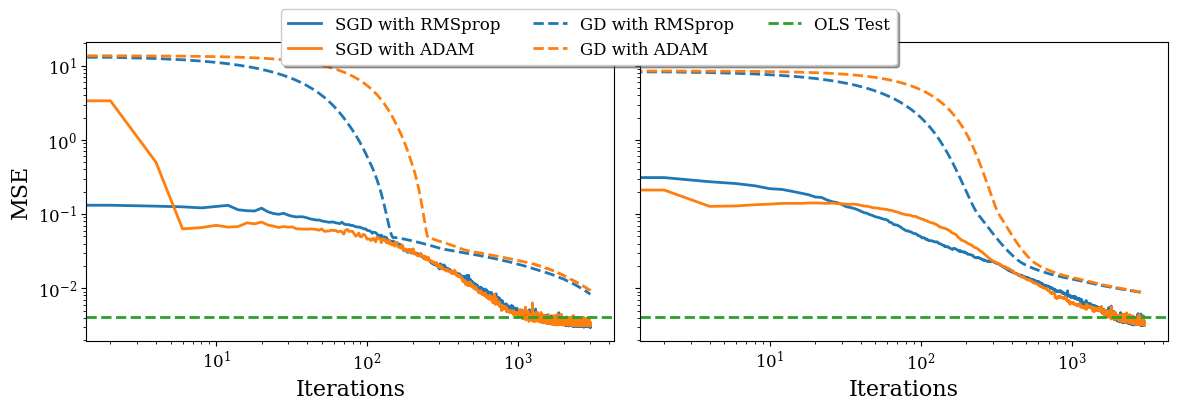

In [17]:
# Plot MSE vs. iterations
fig, axes = plt.subplots(1, len(models), figsize=(12, 4), sharey=True)
for i, (model_title, _) in enumerate(models):
    for j, (training_method_name, _, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        learning_rate = max_log_lr
        for k, (step_method_name, _) in enumerate(step_methods):
            mse_data = all_mse_track_data[i][j][k]
            axes[i].plot(mse_data[:,0][::2], mse_data[:,1][::2], # Every other point to reduce clutter
                     label=f"{training_method_name} with {step_method_name}", 
                     c=f"C{k}", 
                     linestyle = "-" if j == 0 else "--",
            )
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Iterations")
    axes[i].axhline(ols_mse, label="OLS Test", color="C2", linestyle="--")
axes[0].set_ylabel("MSE")
single_legends = axes[0].get_legend_handles_labels()
fig.legend(
    handles=single_legends[0], labels=single_legends[1], 
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=3, fancybox=True, shadow=True
)
plt.savefig("../figs/mse_vs_iterations_best_lr.pdf")
plt.show()